<a href="https://colab.research.google.com/github/lustea0201/Interpretability/blob/master/P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [172]:
import zipfile
import io
import cv2
import glob 
import numpy as np
import random 
import torch 

dtype = torch.float
device = torch.device("cpu") 

!rm -rf main_dir
!rm -rf data.zip

method = {
    1: "import locally", 
    2: "from drive"
    }

m = 2

if (m == 1): 
  from google.colab import files
  uploaded = files.upload()
  data = zipfile.ZipFile(io.BytesIO(uploaded['data.zip']), 'r')

if (m == 2): 
  from google.colab import drive
  drive.mount('/content/drive/')

  data = zipfile.ZipFile("/content/drive/My Drive/Research project/data4/data.zip", 'r')


  




root_dir = "main_dir"
data.extractall(root_dir)
data.close()





Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np

transforms = transforms.Compose( [Resize((100, 120), 1), # shouldn't be necessary change later
                                  ToTensor(), 
                                  Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])


train_data = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transforms)

test_data = ImageFolder(root = os.path.join(root_dir, 'test'), transform = transforms)

idx_to_class = {j:i for i,j in train_data.class_to_idx.items()}


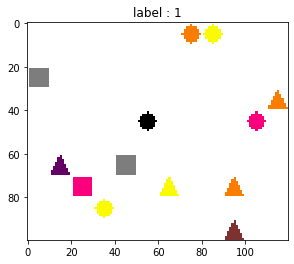

In [174]:
def display_image(image, label): 
  sample_image = image.numpy().transpose(1,2,0)
  mean = np.array([0.5, 0.5, 0.5])
  sd = np.array([0.5, 0.5, 0.5])
  im = sample_image*sd + mean
  plt.imshow(im)
  plt.title("label : " + idx_to_class[label])

display_image(train_data[-1][0], train_data[-1][1])



In [0]:

dataloader = DataLoader(train_data, batch_size = 4, shuffle = True, num_workers = 0)

testloader = DataLoader(test_data, batch_size = 4, shuffle = True, num_workers = 0)

train_loader = iter(dataloader)
x,y = next(train_loader)



https://www.youtube.com/watch?v=fXEdtz8U3Sc

In [0]:
import torch.nn as nn
import torch.nn.functional as F







class Net(nn.Module):
  """
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 2)
  """

  
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(6, 16, 4)
    self.pool2 = nn.MaxPool2d(5)
    self.fc1 = nn.Linear(16 * 9 * 11, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 2)
  

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool2(x)
    x = x.view(-1, self.num_flat_features(x)) #or 16 * 5 * 5 ### now 16*6*5
    y = self.fc1(x)
    x = F.relu(y)
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
  
  def num_flat_features(self, x):
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features


net = Net()


In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [186]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      images = images.to(device)
      labels = labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      if i % 1000 == 999:    # print every 1000 mini-batches
          print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 1000))
          running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 0.000
[1,  2000] loss: 0.000
[1,  3000] loss: 0.000
[1,  4000] loss: 0.000
[1,  5000] loss: 0.000
[1,  6000] loss: 0.000
[1,  7000] loss: 0.000
[1,  8000] loss: 0.000
[1,  9000] loss: 0.000
[1, 10000] loss: 0.002
[1, 11000] loss: 0.000
[1, 12000] loss: 0.000
[1, 13000] loss: 0.000
[1, 14000] loss: 0.000
[1, 15000] loss: 0.000
[1, 16000] loss: 0.000
[1, 17000] loss: 0.000
[1, 18000] loss: 0.000
[1, 19000] loss: 0.000
[1, 20000] loss: 0.000
[1, 21000] loss: 0.000
[1, 22000] loss: 0.000
[1, 23000] loss: 0.000
[1, 24000] loss: 0.000
[1, 25000] loss: 0.000
[1, 26000] loss: 0.000
[1, 27000] loss: 0.001
[1, 28000] loss: 0.000
[1, 29000] loss: 0.000
[1, 30000] loss: 0.000
[1, 31000] loss: 0.000
[1, 32000] loss: 0.000
[1, 33000] loss: 0.006
[1, 34000] loss: 0.005
[1, 35000] loss: 0.002
[1, 36000] loss: 0.000
[1, 37000] loss: 0.000
[1, 38000] loss: 0.000
[1, 39000] loss: 0.000
[1, 40000] loss: 0.000
Finished Training


In [0]:
correct = 0
total = 0
wrong_im = []
wrong_label = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        k = 0
        for truth in (predicted == labels): 
          if not truth: 
            wrong_im.append(images[k])
            wrong_label.append(int(labels[k]))
          k += 1
        
        

print("Accuracy of the network on the " + str(total) + ' test images: %d %%' % (
    100 * correct / total))

print("Number of mistakes : " +str(total-correct))
index = 0

In [0]:
if index in range(len(wrong_im)):
  display_image(wrong_im[index], wrong_label[index])
  index += 1

In [0]:
index = 0